In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow import keras

In [2]:
dataset = keras.utils.image_dataset_from_directory(
    '1files/straw',
    color_mode='rgb',
    batch_size=100,
    image_size=(20, 20),
    shuffle=True,
)

Found 251 files belonging to 1 classes.


In [3]:
images_list = []

for images, labels in dataset:
    images_list.append(images)

images = np.concatenate(images_list, axis=0)


In [4]:
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 100

In [5]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
images = images[:BUFFER_SIZE]

In [6]:
images.shape

(200, 20, 20, 3)

In [7]:
images = images / 255

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
hidden_dim = 2

In [10]:
generator = tf.keras.Sequential([
    
  Dense(5 * 5 * 256, activation='relu', input_shape=(hidden_dim,)), #5х5
  BatchNormalization(),
  LeakyReLU(),
    
  Reshape((5, 5, 256)),
    
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  LeakyReLU(),
    
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'), #10x10
  BatchNormalization(),
  LeakyReLU(),

  Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'), #20x20
    
])

In [11]:
discriminator = tf.keras.Sequential([

Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[20, 20, 3]),
LeakyReLU(),
Dropout(0.3),

Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
LeakyReLU(),
Dropout(0.3),
    
Flatten(),
Dense(1)

])

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [14]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True) # generate img

    real_output = discriminator(images, training=True) # gradient of real in disc
    fake_output = discriminator(generated_images, training=True) # gradient of generated in disc

    gen_loss = generator_loss(fake_output) # loss of generation 
    disc_loss = discriminator_loss(real_output, fake_output) # loss of discriminator

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # calculate gradients 
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply optimizer 
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

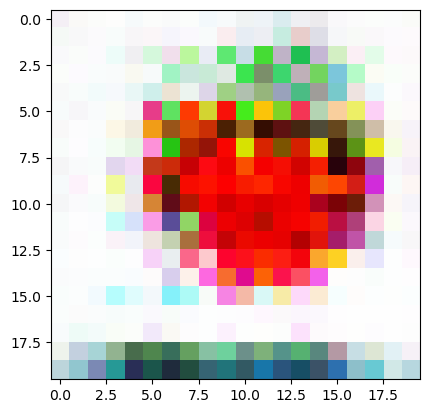

In [34]:
noise = tf.random.normal([BATCH_SIZE, hidden_dim])
generated_images = generator(noise, training=True)
plt.imshow(generated_images[1])

In [18]:
import time
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE / (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

  return history

In [40]:
EPOCHS = 1000
history = train(train_dataset, EPOCHS)

1/1000: =: tf.Tensor(0.8385565, shape=(), dtype=float32)
Время эпохи 1 составляет 0.2666013240814209 секунд
2/1000: =: tf.Tensor(0.86226374, shape=(), dtype=float32)
Время эпохи 2 составляет 0.2225971221923828 секунд
3/1000: =: tf.Tensor(0.8502549, shape=(), dtype=float32)
Время эпохи 3 составляет 0.21621370315551758 секунд
4/1000: =: tf.Tensor(0.87073755, shape=(), dtype=float32)
Время эпохи 4 составляет 0.2563793659210205 секунд
5/1000: =: tf.Tensor(0.80731994, shape=(), dtype=float32)
Время эпохи 5 составляет 0.2822277545928955 секунд
6/1000: =: tf.Tensor(0.8997222, shape=(), dtype=float32)
Время эпохи 6 составляет 0.27861738204956055 секунд
7/1000: =: tf.Tensor(0.88333464, shape=(), dtype=float32)
Время эпохи 7 составляет 0.26802778244018555 секунд
8/1000: =: tf.Tensor(0.8661394, shape=(), dtype=float32)
Время эпохи 8 составляет 0.30341267585754395 секунд
9/1000: =: tf.Tensor(0.8396627, shape=(), dtype=float32)
Время эпохи 9 составляет 0.35705995559692383 секунд
10/1000: =: tf.Tens

1/1 [==============================] - 0s 22ms/step


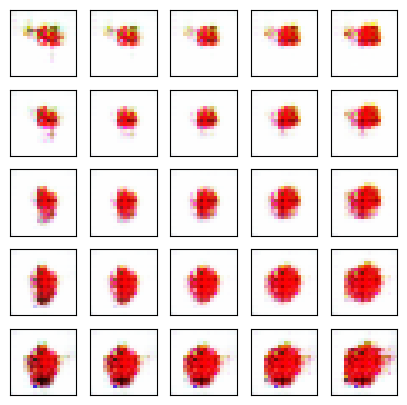

In [41]:
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [43]:
generator.save('20x20_strawnerry_GAN_3000_EPOCHS_generator.keras')

In [44]:
discriminator.save('20x20_strawnerry_GAN_3000_EPOCHS_discriminator.keras')